# 1. Load Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
import time 
import pickle

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

**Note:** Using `CK+`. Mapping from labels to emotions is as follows: 

```0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise```

In [3]:
from data import load_ckplus
from data import EMOTION_MAPPING

train_generator = load_ckplus("train")
validation_generator = load_ckplus("test")

Found 924 images belonging to 8 classes.
Found 384 images belonging to 8 classes.


# 2. Examine the Dataset
**Note:** Once the data is labelled (for demographic attributes such as gender), we can also do data exploration in terms of the dataset balance, etc. 

In [4]:
data = train_generator.next()

Ground truth 0 = neutral


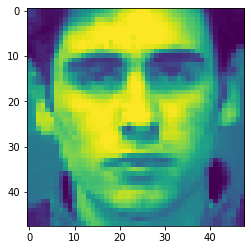

In [5]:
plt.imshow(data[0][0])
label = np.argmax(data[1][0])
print("Ground truth", label, "=", EMOTION_MAPPING[label])

# 3. Defining the Model Architecture
Model architecture defined in Keras in `fer_model.py`. 

Architecture originally proposed by [Goodfellow et al., 2013](https://arxiv.org/pdf/1307.0414.pdf). 

In [6]:
from fer_model import get_fer_model

model = get_fer_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

# 4. Training the Baseline Model 
Baseline here stands for the original, *un-compressed* version. Later we will apply compression strategies on top of it.

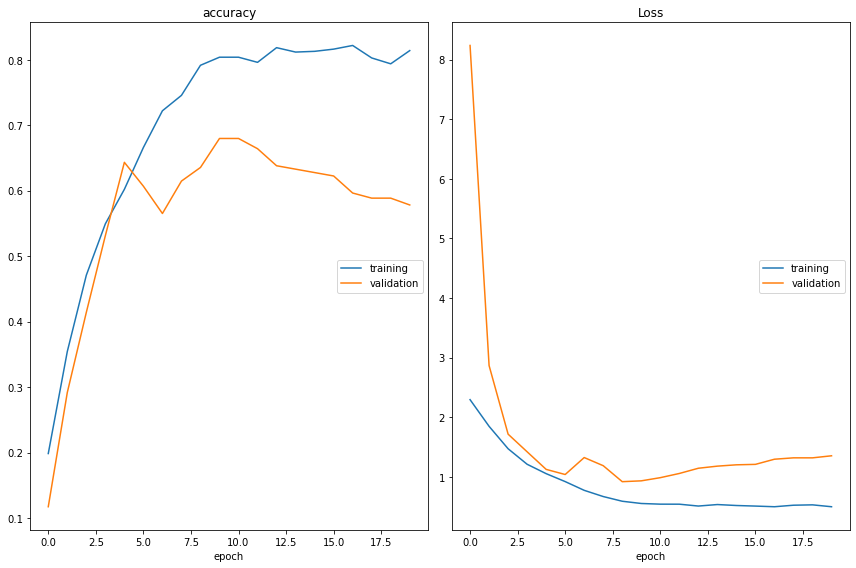

accuracy
	training         	 (min:    0.198, max:    0.822, cur:    0.814)
	validation       	 (min:    0.117, max:    0.680, cur:    0.578)
Loss
	training         	 (min:    0.498, max:    2.294, cur:    0.498)
	validation       	 (min:    0.918, max:    8.235, cur:    1.352)

Epoch 00020: val_accuracy did not improve from 0.67969
28/28 [==============================] - 24s 841ms/step - loss: 0.4980 - accuracy: 0.8139 - val_loss: 1.3525 - val_accuracy: 0.5781
CPU times: user 18min 32s, sys: 8min 5s, total: 26min 38s
Wall time: 7min 53s


In [7]:
%%time
TIMESTAMP = round(time.time())

epochs = 20
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("./weights/model_weights_%s.h5" % TIMESTAMP, monitor='val_accuracy', save_best_only=True,
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Load the "best" weights onto the model. 

In [8]:
model.load_weights("./weights/model_weights_%s.h5" % TIMESTAMP)

In [9]:
with open('./weights/model_history_%s' % TIMESTAMP, 'wb') as model_history_file:
        pickle.dump(history.history, model_history_file)

# 5. Evaluate Baseline

In [10]:
from evaluation import get_metrics
metrics = get_metrics(model, validation_generator)
metrics

{'size': 16512044,
 'acc': 0.6796875,
 'f_acc': 0.6708333333333333,
 'm_acc': 0.6944444444444444,
 'f_acc_breakdown': [0.5333333333333333,
  0.48484848484848486,
  1.0,
  0.7083333333333334,
  0.7142857142857143,
  0.9,
  0.2,
  0.8666666666666667],
 'f_acc_balanced': 0.6759334415584417,
 'm_acc_breakdown': [0.4166666666666667,
  0.4166666666666667,
  1.0,
  0.9523809523809523,
  0.0,
  0.75,
  0.3333333333333333,
  1.0],
 'm_acc_balanced': 0.6086309523809523}

In [11]:
with open('./logs/model_metrics_%s' % TIMESTAMP, 'wb') as model_metrics_file:
        pickle.dump(metrics, model_metrics_file)

### Note: The differences between balanced and unbalanced accuracies can be explained by the distribution of emotions across males and females

In [12]:
from evaluation import get_results
df = get_results(model, validation_generator)

Emotion distribution for female subjects:


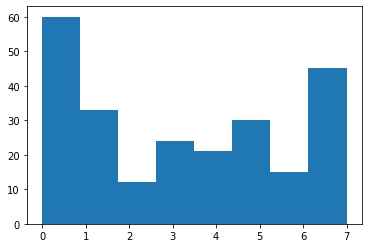

In [13]:
print("Emotion distribution for female subjects:")
plt.hist(df.query("Gender == 'f'")["Ground Truth"], bins=8)
plt.show()

Emotion distribution for male subjects:


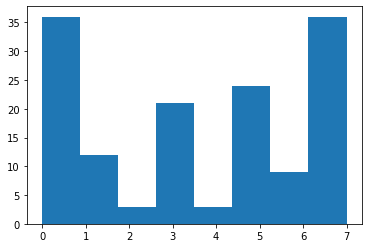

In [14]:
print("Emotion distribution for male subjects:")
plt.hist(df.query("Gender == 'm'")["Ground Truth"], bins=8)
plt.show()

# 6. Visualising the Model

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True,show_layer_names=True)